# Расчёт спектров вторичных антипротонов

В данном блокноте (или записной книже, тетради _от англ. "Notebook"_)
производится вычисление спектров вторичных космических антипротонов
на основе данных, сгенерированных с помощью библиотеки Pythia.

## Подготовка окружения для расчётов и настройки
### Импорт основных модулей, используемых в вычислениях

In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import math
import modelspectra as ms
import plotsettings
import simtf
import plotsettings

### Настройки

In [227]:
# Отрисовывать сгенерированные изображения в блокноте, а не в новом окне:
%matplotlib inline
# Некоторые настройки
# %aimport simtf
# import importlib
# simtf = importlib.reload(simtf)
# plotsettings = importlib.reload(plotsettings)

# Изображения в формате svg, а не png:
# %config InlineBackend.figure_format = 'png'
# %config InlineBackend.figure_format = 'pdf
%config InlineBackend.figure_format = 'svg'

# Расширение iPython для автоматической перезагрузки модулей
%load_ext autoreload

# Установить '%autoreload 0' для отключения перезагрузки модулей
# см. опции: '%autoreload?'
%autoreload 2

### Подготовка окружения

In [193]:
# Номер/имя задачи
TASKNAME = '018'
MODELNAME = 'GM75'
SPECTRUM_FUNC_NAME = 'J_{}'.format(MODELNAME)
ms_func = ms.model_function(MODELNAME)

# Каталог, в котором расположены данные по завершённым задачам моделирования:
DATADIR = 'pythia-pp2pbarx/examples/results/'

# И рабочий каталог:
WORKDIR = DATADIR+TASKNAME+'/'

# Подкаталоги для данных, полученных в ходе анализа
ANALYZED_DATA_DIR = '_analyzed/'
IMAGES_DIR = '_images/'

# Возможный префикс для имён файлов с данными
if TASKNAME in ('001', '002', '003', ):
    DATA_PREFIX = 'WH03_lin_'
else:
    DATA_PREFIX = ''

# Имена файлов с данными расчётов для каждой группы частиц:
# * первичные протоны
# вторичные протоны, антипротоны, нейтроны, антинейтроны
# # 
# # Текстовые данные
# PRIM_P = 'p_prim/{prefx}p_prim.dat'.format(prefx=DATA_PREFIX)
# SEC_P = 'p/{prefx}p.dat'.format(prefx=DATA_PREFIX)
# SEC_PBAR = 'pbar/{prefx}pbar.dat'.format(prefx=DATA_PREFIX)
# SEC_N = 'n/{prefx}n.dat'.format(prefx=DATA_PREFIX)
# SEC_NBAR = 'nbar/{prefx}nbar.dat'.format(prefx=DATA_PREFIX)
# 
# Бинарные данные
PRIM_P = 'p_prim/p_prim.bin'
SEC_P = 'p/p.bin'
SEC_PBAR = 'pbar/pbar.bin'
SEC_N = 'n/n.bin'
SEC_NBAR = 'nbar/nbar.bin'

# Создание подкаталогов для результирующих данных, если такие не существуют:
# 
import os
os.makedirs(WORKDIR+ANALYZED_DATA_DIR, exist_ok=True)
os.makedirs(WORKDIR+IMAGES_DIR, exist_ok=True)

print("Текущий номер задачи:", TASKNAME)
print("Имя модели:", MODELNAME)

Текущий номер задачи: 018
Имя модели: GM75


## Расчёты

### Информация по моделям

Функции спектров первичных протонов для моделей (функции хранятся в модуле `modelspectra`).
##### GM75:
$J_\mathrm{GM\,75}(T_\mathrm{MeV}) =
a \, \left[T_\mathrm{MeV} + b \, \exp\left(c \, T_\mathrm{MeV}\right)\right]^{-2.65}.$<br /><br />
$a = 9.9\,10^7$  (for $[J] = \mathrm{cm}^{-2}\ \mathrm{sr}\ \mathrm{s}\ \mathrm{GeV}/\mathrm{nucl.}$),<br />
$b = 780.0,$ $c = -2.5\cdot 10^{-4}.$

##### BH00:
$J_\mathrm{BH\,00}(T_\mathrm{MeV}) = \frac{\displaystyle a}{\displaystyle 
b\,\left[T_\mathrm{MeV}\,\left(T_\mathrm{MeV} + 2.0\,M_\mathrm{p}\right)\right]^{1.39} +
c\,\left[T_\mathrm{MeV}\,\left(T_\mathrm{MeV} + 2.0\,M_\mathrm{p}\right)\right]^{0.135}
}\,.$<br /><br />
$a = 41.57$ (for $[J] = \mathrm{cm}^{-2}\ \mathrm{sr}\ \mathrm{s}\ \mathrm{GeV}/\mathrm{nucl.}$),<br />
$b = 10^{-7},$ $c = 1.6488,$<br />
$M_\mathrm{p} = 938.272046\ \mathrm{MeV}/c^2.$

##### WH03:
$J_\mathrm{WH\,03}(T_\mathrm{MeV}) = \frac{\displaystyle a}{\displaystyle
b\,T_\mathrm{MeV}^{2.8} +
c\,T_\mathrm{MeV}^{1.58} +
d\,T_\mathrm{MeV}^{0.26}
}\,.$<br /><br />
$a = 53.0$ (for $[J] = \mathrm{cm}^{-2}\ \mathrm{sr}\ \mathrm{s}\ \mathrm{GeV}/\mathrm{nucl.}$),<br />
$b = 10^{-7},$ $c = 2.674\,10^{-3},$ $d = 4.919\,.$

##### LA03:
$J_\mathrm{LA\,03}(T_\mathrm{MeV}) = \begin{cases}
0.1\,\exp{
\left\{
a -
b \, \ln\ln{T_\mathrm{MeV}} +
c \, \sqrt{\ln{T_\mathrm{MeV}}} -
d \, \ln{T_\mathrm{MeV}}
\right\}}\,,\ \text{if}\ T_\mathrm{MeV} \lt 1\ \mathrm{GeV}\,,\\
0.1\,\exp{
\left\{
e -
f \, \ln{T_\mathrm{MeV}} -
\dfrac{g}{\ln{T_\mathrm{MeV}}}
\right\}}\,,\ \text{if}\ T_\mathrm{MeV} \ge 1\ \mathrm{GeV}\,.
\end{cases}$<br /><br />
$a = 0.823\,,$ $b = 0.08\,,$ $c = 1.105\,,$ $d = 9.202\,10^{-2},$<br />
$e = 22.976\,,$ $f = 2.86\,,$ $g = 1.5\,10^{3},$<br />
factor $0.1$ if for $[J] = \mathrm{cm}^{-2}\ \mathrm{sr}\ \mathrm{s}\ \mathrm{GeV}/\mathrm{nucl.}$

##### WH09:
$J_\mathrm{WH\,09}(T_\mathrm{MeV}) = \begin{cases}
0.1 \, \exp{\left\{
a_1 +
b_1 \, (\ln\ln{T_\mathrm{MeV}})^2 +
c_1 \, \sqrt{\ln{T_\mathrm{MeV}}} +
\dfrac{\displaystyle d_1}{\ln{T_\mathrm{MeV}}} +
\dfrac{\displaystyle e_1}{(\ln{T_\mathrm{MeV}})^2}
\right\}}\,,\ \text{if}\ T_\mathrm{MeV} \lt 1\ \mathrm{GeV}\,,\\
0.1 \, \exp{\left\{
b_2 \, (\ln\ln{T_\mathrm{MeV}})^2 +
c_2 \, \sqrt{\ln{T_\mathrm{MeV}}} +
\dfrac{\displaystyle d_2}{\ln{T_\mathrm{MeV}}} +
\dfrac{\displaystyle e_2}{(\ln{T_\mathrm{MeV}})^2}
\right\}}\,,\ \text{if}\ T_\mathrm{MeV} \ge 1\ \mathrm{GeV}\,.
\end{cases}$<br /><br />
$a_1 = -124.47673\,,$ $b_1 = -51.83897\,,$ $c_1 = 131.64886\,,$
$d_1 = -241.72524\,,$ $e_1 = 376.65906\,,$<br />
$b_2 = -51.68612\,,$ $c_2 = 103.58884\,,$ $d_2 = -709.70735\,,$ $e_2 = 1161.55701\,,$<br />
factor $0.1$ if for $[J] = \mathrm{cm}^{-2}\ \mathrm{sr}\ \mathrm{s}\ \mathrm{GeV}/\mathrm{nucl.}$

Здесь везде $T_\mathrm{MeV} = \frac{\displaystyle T}{\displaystyle 1\:\mbox{MeV}}$ — энергия протонов, выраженная в МэВах.

### Графики функций спектров первичных протонов для моделей

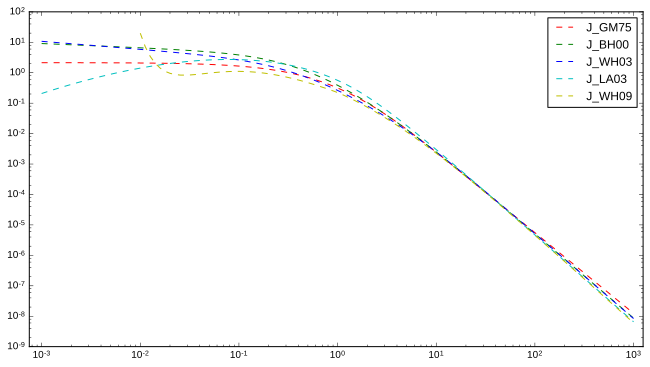

In [229]:
min_x = 1.0E-03
max_x = 1.0E+03

x = np.logspace(math.log(min_x), math.log(max_x), 100, True, base=math.exp(1.0))
plt.xscale('log')
plt.yscale('log')

plt.xlim([0.75*min_x, 1.25*max_x])
# plt.ylim([0.95*min_y, 1.05*max_y])

plt.plot(x, np.vectorize(ms.J_GM75)(x), 'r--', label='J_GM75')
plt.plot(x, np.vectorize(ms.J_BH00)(x), 'g--', label='J_BH00')
plt.plot(x, np.vectorize(ms.J_WH03)(x), 'b--', label='J_WH03')
plt.plot(x, np.vectorize(ms.J_LA03)(x), 'c--', label='J_LA03')
x = np.logspace(math.log(10*min_x), math.log(max_x), 100, True, base=math.exp(1.0))
plt.plot(x, np.vectorize(ms.J_WH09)(x), 'y--', label='J_WH09')
plt.legend()
plt.show()

### Некоторые предварительные проверки

In [8]:
print("Integration in linear coordinates:")
print("J_GM75:", simtf.integrate(ms.J_GM75, 1.0E-03, 1.0E+03, 320000))
print("J_BH00:", simtf.integrate(ms.J_BH00, 1.0E-03, 1.0E+03, 320000))
print("J_WH03:", simtf.integrate(ms.J_WH03, 1.0E-03, 1.0E+03, 320000))
print("J_LA03:", simtf.integrate(ms.J_LA03, 1.0E-03, 1.0E+03, 320000))
print("J_WH09:", simtf.integrate(ms.J_WH09, 1.0E-02, 1.0E+03, 320000))
print("\nIntegration in logarithmic coordinates:")
print("J_GM75:", simtf.logintegrate(ms.J_GM75, 1.0E-03, 1.0E+03, 320000))
print("J_BH00:", simtf.logintegrate(ms.J_BH00, 1.0E-03, 1.0E+03, 320000))
print("J_WH03:", simtf.logintegrate(ms.J_WH03, 1.0E-03, 1.0E+03, 320000))
print("J_LA03:", simtf.logintegrate(ms.J_LA03, 1.0E-03, 1.0E+03, 320000))
print("J_WH09:", simtf.logintegrate(ms.J_WH09, 1.0E-02, 1.0E+03, 320000))
print("\nIntegral and mathematical expectation in linear coordinates:")
print("J_GM75:", simtf.mean_integrate(ms.J_GM75, 1.0E-03, 1.0E+03, 320000))
print("J_BH00:", simtf.mean_integrate(ms.J_BH00, 1.0E-03, 1.0E+03, 320000))
print("J_WH03:", simtf.mean_integrate(ms.J_WH03, 1.0E-03, 1.0E+03, 320000))
print("J_LA03:", simtf.mean_integrate(ms.J_LA03, 1.0E-03, 1.0E+03, 320000))
print("J_WH09:", simtf.mean_integrate(ms.J_WH09, 1.0E-02, 1.0E+03, 320000))
print("\nIntegral and mathematical expectation in logarithmic coordinates:")
print("J_GM75:", simtf.log_mean_integrate(ms.J_GM75, 1.0E-03, 1.0E+03, 320000))
print("J_BH00:", simtf.log_mean_integrate(ms.J_BH00, 1.0E-03, 1.0E+03, 320000))
print("J_WH03:", simtf.log_mean_integrate(ms.J_WH03, 1.0E-03, 1.0E+03, 320000))
print("J_LA03:", simtf.log_mean_integrate(ms.J_LA03, 1.0E-03, 1.0E+03, 320000))
print("J_WH09:", simtf.log_mean_integrate(ms.J_WH09, 1.0E-02, 1.0E+03, 320000))

Integration in linear coordinates:
J_GM75: 1.2037990245341152
J_BH00: 2.0221181448924317
J_WH03: 1.4287252493259723
J_LA03: 1.9727179858119996
J_WH09: 0.8418892493589643

Integration in logarithmic coordinates:
J_GM75: 1.203797834990339
J_BH00: 2.021882576530032
J_WH03: 1.4281971874419512
J_LA03: 1.9727616704546
J_WH09: 0.8380515293955004

Integral and mathematical expectation in linear coordinates:
J_GM75: (1.2274066732790136, 1.2037990245341152)
J_BH00: (0.8273359712770112, 2.0221181448924317)
J_WH03: (0.9589383509911359, 1.4287252493259723)
J_LA03: (1.0748857003120347, 1.9727179858119996)
J_WH09: (1.385552008349373, 0.8418892493589643)

Integral and mathematical expectation in logarithmic coordinates:
J_GM75: (1.2274082468241643, 1.203797834990339)
J_BH00: (0.8274331514533105, 2.021882576530032)
J_WH03: (0.9592940313799653, 1.4281971874419512)
J_LA03: (1.074861358613357, 1.9727616704546)
J_WH09: (1.391855293238145, 0.8380515293955004)


In [12]:
# Демонстрация лучшей сходимости интегралов в логарифмических координатах
print(simtf.integrate(ms.J_WH09, 1.0E-02, 1.0E+03, 160000))
print(simtf.integrate(ms.J_WH09, 1.0E-02, 1.0E+03, 320000))
print(simtf.integrate(ms.J_WH09, 1.0E-02, 1.0E+03, 640000))

print(simtf.logintegrate(ms.J_WH09, 1.0E-02, 1.0E+03, 80000))
print(simtf.logintegrate(ms.J_WH09, 1.0E-02, 1.0E+03, 160000))
print(simtf.logintegrate(ms.J_WH09, 1.0E-02, 1.0E+03, 320000))

0.8511064240263527
0.8418892493589643
0.839069332492712
0.8380515315695849
0.8380515300179785
0.8380515293955004


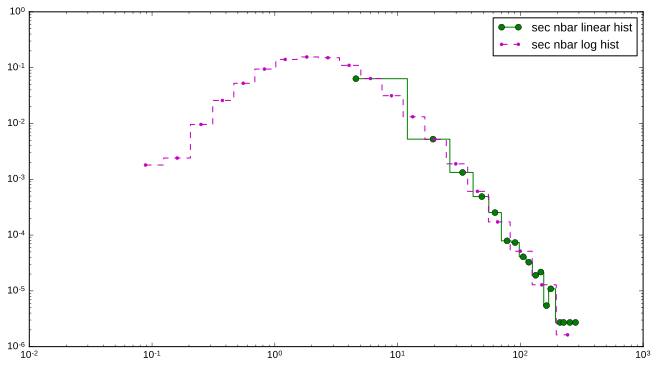

In [231]:
# Данные по вторичным нейтронам из первой задачи
# 
# data = np.genfromtxt(WORKDIR+SEC_NBAR, delimiter=';', names=True)['particle_e_kin']
# data = np.genfromtxt(WORKDIR+'nbar/nbar.dat', delimiter=';', names=True)['particle_e_kin']
# `count=-1` is for all data
data = np.fromfile(WORKDIR+SEC_NBAR, count=-1, )
# 
hist = simtf.histogram(
    pd.Series(data),
    type='means',
    logscale=False,
    n_bins=20,
)

hist_log = simtf.histogram(
    pd.Series(data),
    type='means',
    logscale=True,
    n_bins=20,
)

hist = hist[ ~np.isnan(hist['mean']) ]
hist_log = hist_log[ ~np.isnan(hist_log['mean']) ]

# Подготовка данных для построения графика
x = hist['mean']
y = hist['n_delta_normalized']
min_x, max_x, = x.min(), x.max(),
min_y, max_y, = y.min(), y.max(),
# Для d_y считаем, что он равен длине интервала (0, max_y)
d_x, d_y, = max_x-min_x, max_y,

# Вычисление функции-сплайна, интерполирующей данные
hist_spline = simtf.cubic_spline(xi=hist['mean'].as_matrix(),
                   yi=hist['n_delta_normalized'].as_matrix(),
                   logscale=True)
hist_log_spline = simtf.cubic_spline(xi=hist_log['mean'].as_matrix(),
                   yi=hist_log['n_delta_normalized'].as_matrix(),
                   logscale=True)
x_hist = np.logspace(math.log(min_x), math.log(max_x), 100, True, base=math.exp(1.0))
y_hist = np.vectorize(hist_spline)(x_hist)
y_log_hist = np.vectorize(hist_log_spline)(x_hist)

# Построение графика
# plt.xlim([min_x-0.05*d_x, max_x+0.05*d_x])
# plt.ylim([0.0, max_y+0.05*d_y])
# plt.xlim([0.95*min_x, 1.05*max_x])
# plt.ylim([0.95*min_y, 1.05*max_y])
# plt.xscale('linear')
# plt.yscale('linear')
plt.xscale('log')
plt.yscale('log')
# plt.plot(hist['coo'], y, 'y:o')
plt.plot(x, y, 'go-', drawstyle='steps-mid', label='sec nbar linear hist')
plt.plot(hist_log['mean'], hist_log['n_delta_normalized'], 'm.--', drawstyle='steps-mid', label='sec nbar log hist')
# plt.plot(x_hist, y_hist, 'r.--', drawstyle='steps-mid')
# plt.plot(x_hist, y_log_hist, 'y.--', drawstyle='steps-mid')
plt.legend()
plt.show()

del data, hist, hist_log

In [230]:
%autoreload 0
# %autoreload 2

In [8]:
# Вспомогательная функция для поиска всех делителей
def all_divisors(n, large=True):
    large_divisors = []
    for i in range(1, int(math.sqrt(n) + 1)):
        if n % i == 0:
            yield i
            if i*i != n:
                large_divisors.append(n / i)
    if large:
        for divisor in reversed(large_divisors):
            yield int(divisor)

print(list(all_divisors(1813, large=False)))

[1, 7, 37]


### Загрузка данных для всех групп частиц и сводная информация по ним

In [195]:
# Начальные (первичные) протоны:
# prim_p = np.genfromtxt(WORKDIR+PRIM_P, delimiter=';', names=True)['particle_e_kin']
prim_p = np.fromfile(WORKDIR+PRIM_P, count=-1, )
print(" * Данные для prim p загружены [файл `{}`]".format(WORKDIR+PRIM_P))
# Вторичные протоны, нейтроны, антипротоны и антинейтроны:
# sec_p = np.genfromtxt(WORKDIR+SEC_P, delimiter=';', names=True)['particle_e_kin']
sec_p = np.fromfile(WORKDIR+SEC_P, count=-1, )
print(" * Данные для sec p загружены")
# sec_n = np.genfromtxt(WORKDIR+SEC_N, delimiter=';', names=True)['particle_e_kin']
sec_n = np.fromfile(WORKDIR+SEC_N, count=-1, )
print(" * Данные для sec n загружены")
# sec_pbar = np.genfromtxt(WORKDIR+SEC_PBAR, delimiter=';', names=True)['particle_e_kin']
sec_pbar = np.fromfile(WORKDIR+SEC_PBAR, count=-1, )
print(" * Данные для prim sec pbar загружены")
# sec_nbar = np.genfromtxt(WORKDIR+SEC_NBAR, delimiter=';', names=True)['particle_e_kin']
sec_nbar = np.fromfile(WORKDIR+SEC_NBAR, count=-1, )
print(" * Данные для sec nbar загружены")

# Определение числа интервалов энергий первичных протонов,
# которые давали вклад в рождение вторичных частиц
n_bins = len(
    np.unique(prim_p, return_counts=False)
)

print("Total bins:", n_bins, "\n  Divisors:", ", ".join("{}".format(i) for i in all_divisors(n_bins, large=False)))
print()
print("Первичных протонов:", len(prim_p))
print("Вторичных протонов:", len(sec_p))
print("Вторичных нейтронов:", len(sec_n))
print("Вторичных антипротонов:", len(sec_pbar))
print("Вторичных антинейтронов:", len(sec_nbar))

 * Данные для prim p загружены [файл `pythia-pp2pbarx/examples/results/018/p_prim/p_prim.bin`]
 * Данные для sec p загружены
 * Данные для sec n загружены
 * Данные для prim sec pbar загружены
 * Данные для sec nbar загружены
Total bins: 4000 
  Divisors: 1, 2, 4, 5, 8, 10, 16, 20, 25, 32, 40, 50

Первичных протонов: 5320223
Вторичных протонов: 7490812
Вторичных нейтронов: 3202013
Вторичных антипротонов: 26242
Вторичных антинейтронов: 26137


In [145]:
# Сохранение технической информации
# 
with open(WORKDIR+'taskinfo-{}-{}.txt'.format(TASKNAME, MODELNAME), 'w') as f:
    f.write("Номер/имя задачи: {}\n".format(TASKNAME))
    f.write("Название модели: {}\n".format(MODELNAME))
    f.write("Total bins: {}\n  Divisors: {}\n".format(
            n_bins,
            ", ".join("{}".format(i) for i in all_divisors(n_bins, large=False))
        )
    )
    f.write("\n")
    u = np.unique(prim_p, return_counts=False)
    f.write("Первичные протоны сгенерированы в диапазоне энергий\n [{} ГэВ; {} ГэВ]\n" \
            " с шагом {:.6f} ГэВ\n".format(
            prim_p.min(),
            prim_p.max(),
            u[1]-u[0],
        )
    )
    del u
    f.write("\n")
    f.write("Первичных протонов: {}\n".format(len(prim_p)))
    f.write("Вторичных протонов: {}\n".format(len(sec_p)))
    f.write("Вторичных нейтронов: {}\n".format(len(sec_n)))
    f.write("Вторичных антипротонов: {}\n".format(len(sec_pbar)))
    f.write("Вторичных антинейтронов: {}\n".format(len(sec_nbar)))

### Гистограммы распределений

In [197]:
# Расчёт гистограммы для первичных протонов
# 
# NB: методы "means" и "discrete" лучше всего подходят
# для расчёта гистограммы в случае, когда данные
# представлены регулярными, а не случайными значениями.
prim_p_hist = simtf.histogram(
    pd.Series(prim_p),
    type='means',
#     type='window',
#     type='window_2',
    logscale=False,
#     logscale=True,
#     n_bins=n_bins//4,
    n_bins=n_bins//5,
#     n_bins=n_bins//6,
#     n_bins=n_bins//7,
#     n_bins=n_bins,
    n_points=n_bins,
    window_size=0.01,
)

# Убираем все лишние значения `NaN` и "0":
prim_p_hist = prim_p_hist[ ~np.isnan(prim_p_hist['mean']) ]
prim_p_hist = prim_p_hist[ (prim_p_hist['n_delta_normalized'] != 0) ]
# prim_p_hist = prim_p_hist[ ~np.isnan(prim_p_hist['mean']) | (prim_p_hist['n_delta_normalized'] != 0) ]

In [198]:
# Расчёт гистограммы для вторичных протонов (их тоже много)
# 
sec_p_hist = simtf.histogram(
    pd.Series(sec_p),
    type='means',
#     type='window',
#     type='window_2',
#     logscale=False,
    logscale=True,
#     n_bins=n_bins//4,
    n_bins=n_bins//5,
#     n_bins=n_bins//6,
#     n_bins=n_bins//7,
#     n_bins=n_bins,
    n_points=n_bins,
    window_size=0.01,
)

# Убираем все лишние значения `NaN` и "0":
sec_p_hist = sec_p_hist[ ~np.isnan(sec_p_hist['mean']) ]
sec_p_hist = sec_p_hist[ (sec_p_hist['n_delta_normalized'] != 0) ]
# sec_p_hist = sec_p_hist[ ~np.isnan(sec_p_hist['mean']) | (sec_p_hist['n_delta_normalized'] != 0) ]

In [199]:
# Расчёт гистограмм для вторичных нейтронов (и их много)
# 
sec_n_hist = simtf.histogram(
    pd.Series(sec_n),
    type='means',
#     type='window',
#     type='window_2',
#     logscale=False,
    logscale=True,
#     n_bins=n_bins//4,
    n_bins=n_bins//5,
#     n_bins=n_bins//6,
#     n_bins=n_bins//7,
#     n_bins=n_bins,
    n_points=n_bins,
    window_size=0.01,
)

# Убираем все лишние значения `NaN` и "0":
sec_n_hist = sec_n_hist[ ~np.isnan(sec_n_hist['mean']) ]
sec_n_hist = sec_n_hist[ (sec_n_hist['n_delta_normalized'] != 0) ]
# sec_n_hist = sec_n_hist[ ~np.isnan(sec_n_hist['mean']) | (sec_n_hist['n_delta_normalized'] != 0) ]

In [200]:
# Гистограммы для вторичных антипротонов и антинейтронов
# (их гораздо меньше)
# 
sec_pbar_hist = simtf.histogram(
    pd.Series(sec_pbar),
    type='means',
#     type='window',
#     type='window_2',
#     logscale=False,
    logscale=True,
    n_bins=20,
#     n_bins=n_bins,
    n_points=20,
    window_size=0.05,
)

sec_nbar_hist = simtf.histogram(
    pd.Series(sec_nbar),
    type='means',
#     type='window',
#     type='window_2',
#     logscale=False,
    logscale=True,
    n_bins=20,
#     n_bins=n_bins,
    n_points=20,
    window_size=0.05,
)

# Убираем все лишние значения `NaN` и "0":
sec_pbar_hist = sec_pbar_hist[ ~np.isnan(sec_pbar_hist['mean']) ]
sec_nbar_hist = sec_nbar_hist[ ~np.isnan(sec_nbar_hist['mean']) ]
sec_pbar_hist = sec_pbar_hist[ (sec_pbar_hist['n_delta_normalized'] != 0) ]
sec_nbar_hist = sec_nbar_hist[ (sec_nbar_hist['n_delta_normalized'] != 0) ]
# sec_pbar_hist = sec_pbar_hist[ ~np.isnan(sec_pbar_hist['mean']) | (sec_pbar_hist['n_delta_normalized'] != 0) ]
# sec_nbar_hist = sec_nbar_hist[ ~np.isnan(sec_nbar_hist['mean']) | (sec_nbar_hist['n_delta_normalized'] != 0) ]

In [201]:
# И ещё гистограммы для объединённых данных вторичных частиц (протоны, нейтроны), (антипротоны, антинейтроны).
# 
sec_p_sec_n_hist = simtf.histogram(
    pd.Series(np.append(sec_p, sec_n)),
    type='means',
#     type='window',
#     type='window_2',
#     logscale=False,
    logscale=True,
#     n_bins=n_bins//4,
    n_bins=n_bins//5,
#     n_bins=n_bins//6,
#     n_bins=n_bins//7,
#     n_bins=n_bins,
    n_points=n_bins,
    window_size=0.01,
)

sec_pbar_sec_nbar_hist = simtf.histogram(
    pd.Series(np.append(sec_pbar, sec_nbar)),
    type='means',
#     type='window',
#     type='window_2',
#     logscale=False,
    logscale=True,
    n_bins=20,
#     n_bins=n_bins,
    n_points=20,
    window_size=0.05,
)

# Убираем все лишние значения `NaN` и "0":
sec_p_sec_n_hist = sec_p_sec_n_hist[ ~np.isnan(sec_p_sec_n_hist['mean']) ]
sec_pbar_sec_nbar_hist = sec_pbar_sec_nbar_hist[ ~np.isnan(sec_pbar_sec_nbar_hist['mean']) ]
sec_p_sec_n_hist = sec_p_sec_n_hist[ (sec_p_sec_n_hist['n_delta_normalized'] != 0) ]
sec_pbar_sec_nbar_hist = sec_pbar_sec_nbar_hist[ (sec_pbar_sec_nbar_hist['n_delta_normalized'] != 0) ]
# sec_p_sec_n_hist = sec_p_sec_n_hist[ ~np.isnan(sec_p_sec_n_hist['mean']) | (sec_p_sec_n_hist['n_delta_normalized'] != 0) ]
# sec_pbar_sec_nbar_hist = sec_pbar_sec_nbar_hist[ ~np.isnan(sec_pbar_sec_nbar_hist['mean']) | (sec_pbar_sec_nbar_hist['n_delta_normalized'] != 0) ]

### Интерполяция данных гистограмм сплайнами

In [202]:
# Построение функций-сплайнов для всех частиц
# 
prim_p_spline = simtf.cubic_spline(xi=prim_p_hist['mean'].as_matrix(),
                   yi=prim_p_hist['n_delta_normalized'].as_matrix(),
                   logscale=True)

sec_p_spline = simtf.cubic_spline(xi=sec_p_hist['mean'].as_matrix(),
                   yi=sec_p_hist['n_delta_normalized'].as_matrix(),
                   logscale=True)

sec_n_spline = simtf.cubic_spline(xi=sec_n_hist['mean'].as_matrix(),
                   yi=sec_n_hist['n_delta_normalized'].as_matrix(),
                   logscale=True)

sec_pbar_spline = simtf.cubic_spline(xi=sec_pbar_hist['mean'].as_matrix(),
                   yi=sec_pbar_hist['n_delta_normalized'].as_matrix(),
                   logscale=True)

sec_nbar_spline = simtf.cubic_spline(xi=sec_nbar_hist['mean'].as_matrix(),
                   yi=sec_nbar_hist['n_delta_normalized'].as_matrix(),
                   logscale=True)

sec_p_sec_n_spline = simtf.cubic_spline(xi=sec_p_sec_n_hist['mean'].as_matrix(),
                   yi=sec_p_sec_n_hist['n_delta_normalized'].as_matrix(),
                   logscale=True)

sec_pbar_sec_nbar_spline = simtf.cubic_spline(xi=sec_pbar_sec_nbar_hist['mean'].as_matrix(),
                   yi=sec_pbar_sec_nbar_hist['n_delta_normalized'].as_matrix(),
                   logscale=True)

### Фитирование (подгонка) полученных данных для первичных протонов

Масштаб по оси ординат для функции спектра на основе гистограммы подгоняется
под масштаб исходной (заданной) функции, на основе которой генерировались данные.

**Необходимо задавать правильную модель для вычисления интеграла!**

В случае метода наименьших квадратов для подгонки данных ${x_i, y_i}$ к функции f(x) нормировочный множитель определяется формулой:

$$k_\text{norm} = \dfrac{\sum\limits_i y_i\, f(x_i}{\sum\limits_i y_i^2}\,.$$

In [16]:
# Как вариант — фитирование по методу наименьших квадратов
def least_squares(x, y, func):
    
    return (y * np.vectorize(func)(x)).sum() / (y*y).sum()
#     return np.sum(y * np.vectorize(func)(x)) / np.sum(y*y)

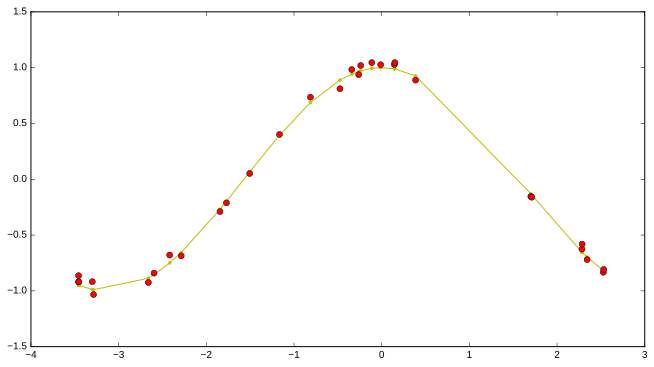

In [237]:
# Тестирование работы функции, реализующей метод наименьших квадратов
x = np.sort(3*np.sin(npr.uniform(0.0, 7.0, 30))+npr.uniform(-3.5,3.5))
y = (1.239+np.sin(npr.uniform(-0.1, 0.1, 30)))*np.cos(x)+np.sin(npr.uniform(-0.03, 0.03, 30))
k_norm = least_squares(x, y, math.cos)

plt.plot(x, np.cos(x), 'y.-')
plt.plot(x, k_norm*y, 'ro')
plt.show()

In [241]:
# Вычисление отношения интегралов на интерполируемом промежутке
prim_p_s = simtf.logintegrate(prim_p_spline, min_x, max_x, 32000)
prim_p_i = simtf.logintegrate(ms_func, min_x, max_x, 320000)

# По результатам вычислений определяется нормировочный множитель:
k_norm = prim_p_i/prim_p_s

# И то же самое, но методом наименьших квадратов:
k_norm_lsq = least_squares(
    x=prim_p_hist['mean'].as_matrix(),
    y=prim_p_hist['n_delta_normalized'].as_matrix(),
    func=ms_func,
#     func=ms.J_WH03,
)

print("Integral (spline): {:.3e}".format(prim_p_s))
print("Integral (original spectrum): {:.3e}".format(prim_p_i))
print("ratio (k_norm): {:.3e}".format(k_norm))
print("k_norm lsq: {:.3e}".format(k_norm_lsq))
print()
print("Min x: {:.3f}; max x: {:.3f}".format(min_x, max_x))
print("Max y: {:.3e}; min y: {:.3e}".format(max_y, min_y))

Integral (spline): 8.669e-01
Integral (original spectrum): 2.857e-02
ratio (k_norm): 3.295e-02
k_norm lsq: 3.306e-02

Min x: 6.705; max x: 999.379
Max y: 2.047e-01; min y: 7.567e-07


In [204]:
print(simtf.logintegrate(sec_p_spline, sec_p.min(), sec_p.max(), 32000))
print(simtf.logintegrate(sec_n_spline, sec_n.min(), sec_n.max(), 32000))
print(simtf.logintegrate(sec_pbar_spline, sec_pbar.min(), sec_pbar.max(), 32000))
print(simtf.logintegrate(sec_nbar_spline, sec_nbar.min(), sec_nbar.max(), 32000))
print(simtf.logintegrate(sec_p_sec_n_spline, min(sec_p.min(), sec_n.min()), max(sec_p.max(), sec_n.max()), 32000))
print(simtf.logintegrate(sec_pbar_sec_nbar_spline, min(sec_pbar.min(), sec_nbar.min()), max(sec_pbar.max(), sec_nbar.max()), 32000))

1.0013221393
0.99999876062
0.986309060564
0.984251306294
1.00074886263
0.98244759843


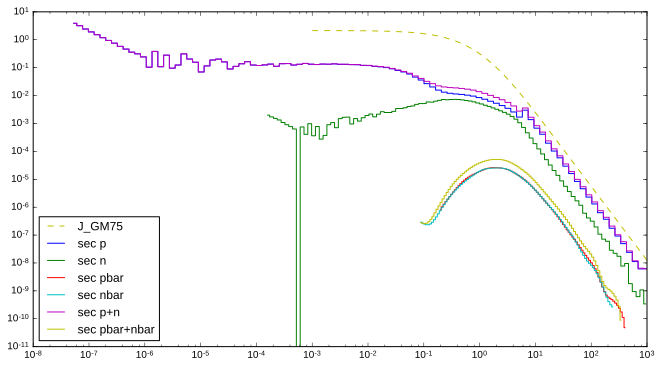

In [244]:
# Подготовка данных для построения графика
# 
# Переменные, в которых хранится общее число частиц:
(
    prim_p_count, sec_p_count, sec_n_count, sec_pbar_count, sec_nbar_count, 
) = (
    len(prim_p),  len(sec_p),  len(sec_n),  len(sec_pbar),  len(sec_nbar), 
)

# === Первичные протоны ===
prim_p_x = prim_p_hist['mean']
prim_p_y = prim_p_hist['n_delta_normalized']

x = prim_p_x
y = prim_p_y
min_x, max_x, = x.min(), x.max(),
min_y, max_y, = y.min(), y.max(),

# Для d_y считаем, что он равен длине интервала (0, max_y)
d_x, d_y, = max_x-min_x, max_y,

# Метод, основанный на наименьших квадратах, даёт
# результат точнее, с меньшей погрешностью, чем 
# метод, основанный на интегрировании
# 
# prim_p_spline_x = np.logspace(math.log(min_x), math.log(max_x), 100, True, base=math.exp(1.0))
# prim_p_spline_x = np.logspace(math.log(1.0E-02), math.log(max_x), 100, True, base=math.exp(1.0))
prim_p_spline_x = np.logspace(math.log(1.0E-03), math.log(max_x), 100, True, base=math.exp(1.0))
# prim_p_spline_y = k_norm * np.vectorize(prim_p_spline)(prim_p_spline_x)
prim_p_spline_y = k_norm_lsq * np.vectorize(prim_p_spline)(prim_p_spline_x)

y_J = np.vectorize(ms_func)(prim_p_spline_x)
# y_J = np.vectorize(ms.J_WH03)(prim_p_spline_x)

# === Вторичные протоны ===
sec_p_x = sec_p_hist['mean']
sec_p_y = sec_p_hist['n_delta_normalized']

sec_p_spline_x = np.logspace(math.log(sec_p_x.min()), math.log(sec_p_x.max()), 100, True, base=math.exp(1.0))
# sec_p_spline_y = k_norm * (sec_p_count/prim_p_count) * np.vectorize(sec_p_spline)(sec_p_spline_x)
sec_p_spline_y = k_norm_lsq * (sec_p_count/prim_p_count) * np.vectorize(sec_p_spline)(sec_p_spline_x)

# === Вторичные нейтроны ===
sec_n_x = sec_n_hist['mean']
sec_n_y = sec_n_hist['n_delta_normalized']

sec_n_spline_x = np.logspace(math.log(sec_n_x.min()), math.log(sec_n_x.max()), 100, True, base=math.exp(1.0))
# sec_n_spline_y = k_norm * (sec_n_count/prim_p_count) * np.vectorize(sec_n_spline)(sec_n_spline_x)
sec_n_spline_y = k_norm_lsq * (sec_n_count/prim_p_count) * np.vectorize(sec_n_spline)(sec_n_spline_x)

# === Вторичные антипротоны ===
sec_pbar_x = sec_pbar_hist['mean']
sec_pbar_y = sec_pbar_hist['n_delta_normalized']

sec_pbar_spline_x = np.logspace(math.log(sec_pbar_x.min()), math.log(sec_pbar_x.max()), 100, True, base=math.exp(1.0))
# sec_pbar_spline_y = k_norm * (sec_pbar_count/prim_p_count) * np.vectorize(sec_pbar_spline)(sec_pbar_spline_x)
sec_pbar_spline_y = k_norm_lsq * (sec_pbar_count/prim_p_count) * np.vectorize(sec_pbar_spline)(sec_pbar_spline_x)

# === Вторичные антинейтроны ===
sec_nbar_x = sec_nbar_hist['mean']
sec_nbar_y = sec_nbar_hist['n_delta_normalized']

sec_nbar_spline_x = np.logspace(math.log(sec_nbar_x.min()), math.log(sec_nbar_x.max()), 100, True, base=math.exp(1.0))
# sec_nbar_spline_y = k_norm * (sec_nbar_count/prim_p_count) * np.vectorize(sec_nbar_spline)(sec_nbar_spline_x)
sec_nbar_spline_y = k_norm_lsq * (sec_nbar_count/prim_p_count) * np.vectorize(sec_nbar_spline)(sec_nbar_spline_x)

# === Вторичные протоны И нейтроны ===
sec_p_sec_n_x = sec_p_sec_n_hist['mean']
sec_p_sec_n_y = sec_p_sec_n_hist['n_delta_normalized']

sec_p_sec_n_spline_x = np.logspace(math.log(sec_p_sec_n_x.min()), math.log(sec_p_sec_n_x.max()), 100, True, base=math.exp(1.0))
# sec_p_sec_n_spline_y = k_norm * ((sec_p_count+sec_n_count)/prim_p_count) * np.vectorize(sec_p_sec_n_spline)(sec_p_sec_n_spline_x)
sec_p_sec_n_spline_y = k_norm_lsq * ((sec_p_count+sec_n_count)/prim_p_count) * np.vectorize(sec_p_sec_n_spline)(sec_p_sec_n_spline_x)

# === Вторичные антипротоны И антинейтроны ===
sec_pbar_sec_nbar_x = sec_pbar_sec_nbar_hist['mean']
sec_pbar_sec_nbar_y = sec_pbar_sec_nbar_hist['n_delta_normalized']

sec_pbar_sec_nbar_spline_x = np.logspace(math.log(sec_pbar_sec_nbar_x.min()), math.log(sec_pbar_sec_nbar_x.max()), 100, True, base=math.exp(1.0))
# sec_pbar_sec_nbar_spline_y = k_norm * ((sec_pbar_count+sec_nbar_count)/prim_p_count) * np.vectorize(sec_pbar_sec_nbar_spline)(sec_pbar_sec_nbar_spline_x)
sec_pbar_sec_nbar_spline_y = k_norm_lsq * ((sec_pbar_count+sec_nbar_count)/prim_p_count) * np.vectorize(sec_pbar_sec_nbar_spline)(sec_pbar_sec_nbar_spline_x)

# Построение графика
# plt.xlim([min_x-0.05*d_x, max_x+0.05*d_x])
# plt.ylim([0.0, max_y+0.05*d_y])
# plt.xlim([0.95*min_x, 1.05*max_x])
# plt.ylim([0.95*min_y, 1.05*max_y])

# plt.xscale('linear')
# plt.yscale('linear')
plt.xscale('log')
plt.yscale('log')

plt.plot(prim_p_spline_x, y_J, 'y--', label=SPECTRUM_FUNC_NAME)
# plt.plot(x, k_norm*y, 'g.-',
# #      drawstyle='steps-mid',
#     label='prim p',
# )

# plt.plot(x, k_norm_lsq*y, 'b.--', drawstyle='steps-mid', label='prim p')
# plt.plot(prim_p_spline_x, prim_p_spline_y, 'r.-', drawstyle='steps-mid', label='prim p [spline]')

plt.plot(sec_p_spline_x, sec_p_spline_y, '-', drawstyle='steps-mid', label='sec p')
plt.plot(sec_n_spline_x, sec_n_spline_y, '-', drawstyle='steps-mid', label='sec n')
plt.plot(sec_pbar_spline_x, sec_pbar_spline_y, '-', drawstyle='steps-mid', label='sec pbar')
plt.plot(sec_nbar_spline_x, sec_nbar_spline_y, '-', drawstyle='steps-mid', label='sec nbar')
plt.plot(sec_p_sec_n_spline_x, sec_p_sec_n_spline_y, '-', drawstyle='steps-mid', label='sec p+n')
plt.plot(sec_pbar_sec_nbar_spline_x, sec_pbar_sec_nbar_spline_y, '-', drawstyle='steps-mid', label='sec pbar+nbar')

plt.legend(loc='lower left', )

# plt.savefig(WORKDIR+IMAGES_DIR+'{}-{}-spectra_bins_div23-logscale-hist-for-sec.svg'.format(TASKNAME, MODELNAME))
# plt.savefig(WORKDIR+IMAGES_DIR+'{}-{}-spectra_bins_div23-logscale-hist-for-sec.png'.format(TASKNAME, MODELNAME))
plt.show()

In [242]:
print(k_norm*sec_p_spline(50.))
print(k_norm_lsq*sec_p_spline(50.))

7.93048643937e-06
7.95571157913e-06


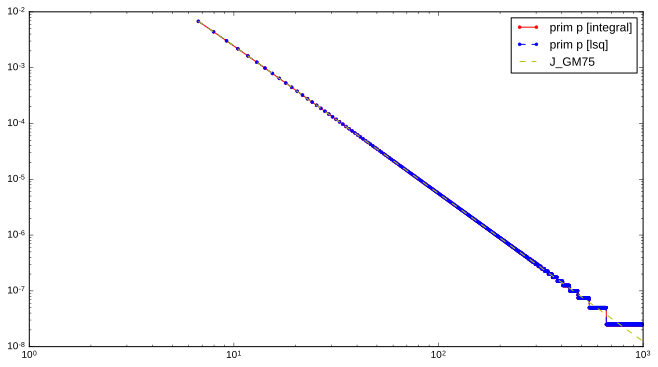

In [243]:
plt.xscale('log')
plt.yscale('log')

plt.plot(x, k_norm*y, 'r.-', label='prim p [integral]')
plt.plot(x, k_norm_lsq*y, 'b.--', label='prim p [lsq]')
plt.plot(prim_p_spline_x, y_J, 'y--', label=SPECTRUM_FUNC_NAME)

plt.legend()
plt.show()

### Сохранение данных для дальнейшей работы

In [178]:
sec_p_spline_x.tofile(WORKDIR+ANALYZED_DATA_DIR+'_sec_p_spline_x.bin')
sec_p_spline_y.tofile(WORKDIR+ANALYZED_DATA_DIR+'_sec_p_spline_y.bin')
sec_n_spline_x.tofile(WORKDIR+ANALYZED_DATA_DIR+'_sec_n_spline_x.bin')
sec_n_spline_y.tofile(WORKDIR+ANALYZED_DATA_DIR+'_sec_n_spline_y.bin')
sec_pbar_spline_x.tofile(WORKDIR+ANALYZED_DATA_DIR+'_sec_pbar_spline_x.bin')
sec_pbar_spline_y.tofile(WORKDIR+ANALYZED_DATA_DIR+'_sec_pbar_spline_y.bin')
sec_nbar_spline_x.tofile(WORKDIR+ANALYZED_DATA_DIR+'_sec_nbar_spline_x.bin')
sec_nbar_spline_y.tofile(WORKDIR+ANALYZED_DATA_DIR+'_sec_nbar_spline_y.bin')
sec_p_sec_n_spline_x.tofile(WORKDIR+ANALYZED_DATA_DIR+'_sec_p_sec_n_spline_x.bin')
sec_p_sec_n_spline_y.tofile(WORKDIR+ANALYZED_DATA_DIR+'_sec_p_sec_n_spline_y.bin')
sec_pbar_sec_nbar_spline_x.tofile(WORKDIR+ANALYZED_DATA_DIR+'_sec_pbar_sec_nbar_spline_x.bin')
sec_pbar_sec_nbar_spline_y.tofile(WORKDIR+ANALYZED_DATA_DIR+'_sec_pbar_sec_nbar_spline_y.bin')